In [1]:
from google.colab import files
up = files.upload()  # selecciona "datohorario20250919.xlsx" (u otro nombre)

FILENAME = next(iter(up.keys()))   # usa el nombre del archivo subido
TARGET_COL = None                  # Opcional: fija objetivo, p.ej. "TEMP" o "PNM" (None = auto)
TEST_SIZE = 0.2
RANDOM_STATE = 42

# ---- 1) Imports ----
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


Saving datohorario20250919.xlsx to datohorario20250919.xlsx


In [2]:
# 2) Lectura y PARSEO específico de este formato
raw = pd.read_excel(FILENAME, sheet_name=0, header=None)
s = raw.iloc[:, 0].dropna().astype(str).str.strip()
s = s[s.ne("")].reset_index(drop=True)

header_line = re.sub(r"\s+", " ", s.iloc[0]).strip()
cols = header_line.split()

has_units = s.iloc[1].find("[") != -1 if len(s) > 1 else False
data_start = 2 if has_units else 1

n_splits = max(len(cols) - 1, 1)
data = s.iloc[data_start:].str.replace(r"\s+", " ", regex=True).str.split(" ", n=n_splits, expand=True)
data.columns = cols

In [3]:
# 3) Limpieza y tipos

for c in data.columns:
    data[c] = data[c].astype(str).str.strip()

if "FECHA" not in data.columns or "HORA" not in data.columns:
    raise ValueError("No se encontraron columnas FECHA y HORA en el encabezado.")

def to_num(s):
    return pd.to_numeric(s.str.replace(",", ".", regex=False), errors="coerce")

num_candidates = []
for c in ["TEMP","HUM","PNM","DD","FF"]:
    if c in data.columns:
        data[c] = to_num(data[c])
        num_candidates.append(c)

fecha = pd.to_datetime(data["FECHA"], format="%d%m%Y", errors="coerce")
hora = to_num(data["HORA"]).astype("Int64")

valid = fecha.notna() & hora.notna()
df = data.loc[valid].copy()
dt = fecha[valid] + pd.to_timedelta(hora[valid].astype(int), unit="h")
df.index = dt
df = df.drop(columns=["FECHA","HORA"])

for c in df.columns:
    if c not in num_candidates and c != "NOMBRE":
        conv = pd.to_numeric(df[c].str.replace(",", ".", regex=False), errors="ignore") if df[c].dtype==object else df[c]
        df[c] = conv

In [4]:
# ---- 4) Exploración rápida ----
print("Forma:", df.shape)
print("Columnas:", list(df.columns))
print("Tipos:\n", df.dtypes)
print("Nulos por columna (top 10):\n", df.isna().sum().sort_values(ascending=False).head(10))
display(df.head(12))

if len(df) < 50:
    raise ValueError("Hay muy pocas filas para modelar (se recomiendan > 100). Revisa la carga.")

Forma: (2053, 6)
Columnas: ['TEMP', 'HUM', 'PNM', 'DD', 'FF', 'NOMBRE']
Tipos:
 TEMP      float64
HUM       float64
PNM       float64
DD        float64
FF        float64
NOMBRE     object
dtype: object
Nulos por columna (top 10):
 FF        207
TEMP        0
HUM         0
PNM         0
DD          0
NOMBRE      0
dtype: int64


,TEMP,HUM,PNM,DD,FF,NOMBRE
2025-09-19 00:00:00,19.0,87.0,1012.7,60.0,15.0,AEROPARQUE AERO
2025-09-19 01:00:00,18.8,88.0,1011.8,40.0,11.0,AEROPARQUE AERO
2025-09-19 02:00:00,18.6,91.0,1011.0,30.0,15.0,AEROPARQUE AERO
2025-09-19 03:00:00,18.5,92.0,1010.5,10.0,13.0,AEROPARQUE AERO
2025-09-19 04:00:00,18.3,90.0,1010.4,340.0,11.0,AEROPARQUE AERO
2025-09-19 05:00:00,18.1,92.0,1010.2,340.0,11.0,AEROPARQUE AERO
2025-09-19 06:00:00,18.1,91.0,1010.7,330.0,9.0,AEROPARQUE AERO
2025-09-19 07:00:00,18.0,91.0,1011.0,350.0,9.0,AEROPARQUE AERO
2025-09-19 08:00:00,18.5,92.0,1011.5,360.0,11.0,AEROPARQUE AERO
2025-09-19 09:00:00,18.7,90.0,1011.6,360.0,13.0,AEROPARQUE AERO


In [5]:
# 5) Selección de TARGET
if TARGET_COL is None:
    prefs = ["TEMP","PM2.5","PM10","NO2","O3","CO","SO2","PNM","HUM","FF"]
    found = [c for c in prefs if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    if found:
        TARGET_COL = found[0]
    else:
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if not numeric_cols:
            raise ValueError("No hay columnas numéricas para usar como objetivo.")
        TARGET_COL = numeric_cols[-1]

print("TARGET seleccionado:", TARGET_COL)

TARGET seleccionado: TEMP


In [6]:
# ---- 6) Construir X, y + features temporales ----
X = df.drop(columns=[TARGET_COL], errors="ignore").copy()
y = df[TARGET_COL].copy()

# Features temporales
X["hour"] = X.index.hour
X["dayofweek"] = X.index.dayofweek
X["month"] = X.index.month
X["is_weekend"] = (X.index.dayofweek >= 5).astype(int)

# Detección de tipos
num_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_features = [c for c in X.columns if c not in num_features]

# ---- 7) Split temporal (último 20% para test) ----
split_idx = int((1 - TEST_SIZE) * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [9]:
# 8) Preprocesamiento y modelos
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ]
)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
}

results = []
store = {}
for name, mdl in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", mdl)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    results.append({"modelo": name, "MAE": mae, "RMSE": rmse, "R2": r2})
    store[name] = (pipe, pd.Series(pred, index=y_test.index))

metrics = pd.DataFrame(results).sort_values("RMSE")
display(metrics)

best_name = metrics.iloc[0]["modelo"]
best_pipe, y_pred = store[best_name]
print("Mejor modelo:", best_name)

,modelo,MAE,RMSE,R2
1,RandomForest,3.375653,29.332945,0.515521
0,LinearRegression,5.890985,44.521608,0.264657


Mejor modelo: RandomForest


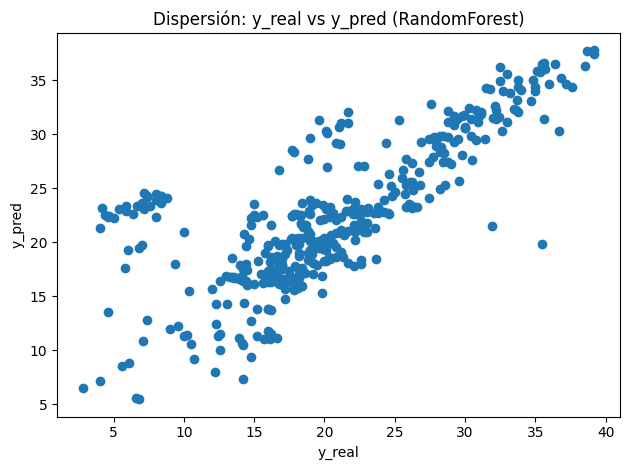

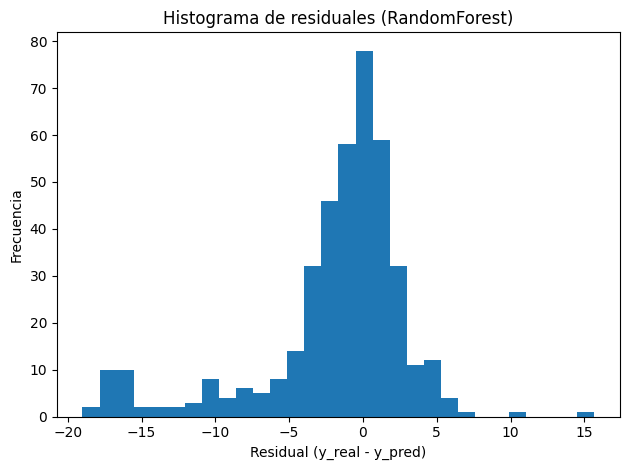

Predicciones + métricas guardadas en: predicciones_resultados.csv


In [11]:
# ---- 9) Gráficas (matplotlib, 1 figura por gráfico, sin estilos/colores) ----
plt.figure()
plt.scatter(y_test, y_pred)
plt.title(f"Dispersión: y_real vs y_pred ({best_name})")
plt.xlabel("y_real")
plt.ylabel("y_pred")
plt.tight_layout()
plt.show()

resid = (y_test - y_pred)
plt.figure()
plt.hist(resid.dropna(), bins=30)
plt.title(f"Histograma de residuales ({best_name})")
plt.xlabel("Residual (y_real - y_pred)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# ---- 10) Exportar predicciones + métricas ----
out = pd.DataFrame({
    "timestamp": y_test.index.astype(str),
    "y_real": y_test.values,
    "y_pred": y_pred.values
})
for r in results:
    for k in ["MAE", "RMSE", "R2"]:
        out[f"{r['modelo']}_{k}"] = r[k]
out_path = "predicciones_resultados.csv"
out.to_csv(out_path, index=False)
print("Predicciones + métricas guardadas en:", out_path)